# Example of creating and running a Metropolis-Hastings Sampler

In this notebook we will setup a sampler to sample a 2D Gaussian distribution with mean $\bar{x} = 2, \bar{y} = 5$ and variance $\sigma_x^2 = 1$, $\sigma_y^2 = 2$; $\sigma^2_{xy} = \sigma^2_{yx} = 0$, using a prior that is uniform over $x \in [-20, 20)$, $y\in[-40, 40)$.

We will use Python's multiprocessing to evolve 12 chains using 4 cores. We will demonstrate that resuming a sampler from it's state attribute yields the same results as if we had run continuously. We then make a plot of the posterior. Finally, we make an animation showing how the 12 chains moved.

In [1]:
%matplotlib notebook
from matplotlib import pyplot
import numpy

import epsie
from epsie.samplers import MetropolisHastingsSampler
import multiprocessing

## Create the model to sample

***Note:*** Below we create a class with several functions to draw samples from the prior and to evaluate the log posterior. This isn't strictly necessary. The only thing the Sampler really requires is a function that it can pass keyword arguments to and get back a tuple of (log likelihood, log prior). However, setting things up as a class will make it convenient to, e.g., draw random samples from the prior for the starting positiions, as well as plot the model later on.

In [2]:
from scipy import stats
class Model(object):
    def __init__(self):
        # we'll use a 2D Gaussian for the likelihood distribution
        self.params = ['x', 'y']
        self.mean = [2., 5.]
        self.cov = [[1., 0.], [0., 2.]]
        self.likelihood_dist = stats.multivariate_normal(mean=self.mean,
                                                         cov=self.cov)

        # we'll just use a uniform prior
        self.prior_bounds = {'x': (-20., 20.),
                             'y': (-40., 40.)}
        xmin = self.prior_bounds['x'][0]
        dx = self.prior_bounds['x'][1] - xmin
        ymin = self.prior_bounds['y'][0]
        dy = self.prior_bounds['y'][1] - ymin
        self.prior_dist = {'x': stats.uniform(xmin, dx),
                           'y': stats.uniform(ymin, dy)}

    def prior_rvs(self, size=None):
        return {p: self.prior_dist[p].rvs(size=size)
                for p in self.params}
    
    def logprior(self, **kwargs):
        return sum([self.prior_dist[p].logpdf(kwargs[p]) for p in self.params])
    
    def loglikelihood(self, **kwargs):
        return self.likelihood_dist.logpdf([kwargs[p] for p in self.params])
    
    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -numpy.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp

In [3]:
model = Model()

## Setup and run the sampler

Create a pool of 4 parallel processes, then initialize the sampler using the model we created above.

In [4]:
nchains = 12
nprocs = 4
pool = multiprocessing.Pool(nprocs)
#pool = None

sampler = MetropolisHastingsSampler(model.params, model, nchains, pool=pool)

Now set the starting positions of the chains by drawing random variates from the model's prior.

In [5]:
sampler.start_position = model.prior_rvs(size=nchains)

### Let's run it!

This will evolve each chain in the collection by 256 steps. This is parallelized over the pool of processes.

In [6]:
sampler.run(256)

## Extract results

We can get the history of all of the chains using the `.positions` attribute. This will return a numpy structured array in which the fields are the parameters names (in this case, `'x'` and `'y'`), and with shape `nchains x niterations`:

In [7]:
positions = sampler.positions
print('sampler.positions: {}'.format(type(positions)))
print('with fields: {}'.format(positions.dtype.names))
print('and shape:', positions.shape)

sampler.positions: <class 'numpy.ndarray'>
with fields: ('x', 'y')
and shape: (12, 256)


This (or any structured array returned by epsie) can be turned into a dictionary of arrays, where the keys are the parameter names, using `epsie.array2dict`:

In [8]:
positions = epsie.array2dict(sampler.positions)
print('sampler.positions: {} with keys/values:'.format(type(positions)))
for param in sorted(positions):
    print('"{}": {} with shape {}'.format(param, type(positions[param]), positions[param].shape))

sampler.positions: <class 'dict'> with keys/values:
"x": <class 'numpy.ndarray'> with shape (12, 256)
"y": <class 'numpy.ndarray'> with shape (12, 256)


We can also access the history of log likelihoods and log priors using `sampler.stats`, as well as the acceptance ratios and which jumps were accepted with `sampler.acceptance`:

In [9]:
stats = sampler.stats
print('sampler.stats: {}'.format(type(stats)))
print('with fields: {}'.format(stats.dtype.names))
print('and shape:', stats.shape)

sampler.stats: <class 'numpy.ndarray'>
with fields: ('logl', 'logp')
and shape: (12, 256)


In [10]:
acceptance = sampler.acceptance
print('sampler.acceptance: {}'.format(type(acceptance)))
print('with fields: {}'.format(acceptance.dtype.names))
print('and shape:', acceptance.shape)

sampler.acceptance: <class 'numpy.ndarray'>
with fields: ('acceptance_ratio', 'accepted')
and shape: (12, 256)


If the model returned "blobs" (i.e., the model returns a dictionary along with the logl and logp), then we can also access those using `sampler.blobs`. Similar to `positions`, this would also be a dictionary of arrays with keys given by the names in the dictionary the model returned. However, because our model above returns no blobs, in this case we just get `None`:

In [11]:
print(sampler.blobs)

None


The individual chains can be accessed using the `.chains` attribute:

In [12]:
sampler.chains

## Resume from a state

The sampler can be checkpointed by getting its current state with `sampler.state`. To demonstrate this, we'll get the current state of the sampler, then run it for another set of iterations. We'll then create a new sampler, and set it's state to the state we obtained from first sampler. Running the same sampler for the same number of iterations should produce the same results.

In [13]:
# get the current state
state = sampler.state

In [14]:
# now advance the sampler for another 256 iterations
sampler.run(256)

In [15]:
# create a new sampler, but set it's state to what the original sampler's was after the first 250 iterations
sampler2 = MetropolisHastingsSampler(model.params, model, nchains, pool=pool)
sampler2.set_state(state)

In [16]:
# now advance the new sampler for 256 iterations
# note that we don't have to run set_start first, since the starting positions have been set by set_start
sampler2.run(256)

In [17]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,-1] == sampler2.acceptance['acceptance_ratio'][:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,-1] == sampler2.acceptance['accepted'][:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


## Clearing memory and continuing

The history of results in memory can be cleared using `.clear()`. Running the sampler after a clear yields the same results as if no clear had been done. This is useful for keeping memory usage down: you can dump results to a file after some number of iterations, clear, then continue.

To demonstrate this, we'll clear `sampler2`, then run both `sampler` and `sampler2` for another 512 iterations. We'll then compare the current results; they should be the same.

In [18]:
sampler2.clear()

In [19]:
sampler.run(512)
sampler2.run(512)

In [20]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,-1] == sampler2.acceptance['acceptance_ratio'][:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,-1] == sampler2.acceptance['accepted'][:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


## Plot the posterior
Let's create a scatter plot of the posterior. For this, we'll need to throw out some earlier samples for the burn-in period; we'll just assume the first-half of the chains were burn in. We also need to calculate the autocorrelation length of the chains in order to get independent samples.

In [21]:
def calculate_acf(data):
    """Calculates the autocorrelation of some data"""
    # zero the mean
    data = data - data.mean()
    # zero-pad to 2 * nearest power of 2
    newlen = int(2**(1+numpy.ceil(numpy.log2(len(data)))))
    x = numpy.zeros(newlen)
    x[:len(data)] = data[:]
    # correlate
    acf = numpy.correlate(x, x, mode='full')
    # drop corrupted region
    acf = acf[len(acf)//2:]
    # normalize
    acf /= acf[0]
    return acf

def calculate_acl(data):
    """Calculates the autocorrelation length of some data.
    
    Algorithm used is from:
    N. Madras and A.D. Sokal, J. Stat. Phys. 50, 109 (1988).
    """
    # calculate the acf
    acf = calculate_acf(data)
    # now the ACL: Following from Sokal, this is estimated
    # as the first point where M*tau[k] <= k, where
    # tau = 2*cumsum(acf) - 1, and M is a tuneable parameter,
    # generally chosen to be = 5 (which we use here)
    m = 5
    cacf = 2.*numpy.cumsum(acf) - 1.
    win = m * cacf <= numpy.arange(len(cacf))
    if win.any():
        acl = int(numpy.ceil(cacf[numpy.where(win)[0][0]]))
    else:
        # data is too short to estimate the ACL, just choose
        # the length of the data
        acl = len(data)
    return acl

Since the chains are completely independent of each other, we can calculate the ACL separately for each chain. However, if you'd like to be more conservative, you can also just take the max over all of the chains.

In [22]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples = sampler.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls = numpy.zeros(nchains, dtype=int)
thinned_arrays = {'x': [], 'y': []}
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    # get the second half of the chains
    sx = samples['x'][ii, burnin_iter:]
    sy = samples['y'][ii, burnin_iter:]
    # compute the acl for each parameter
    aclx = calculate_acl(sx)
    acly = calculate_acl(sy)
    acl = max(aclx, acly)
    acls[ii] = acl
    # note that we'll thin the arrays starting from the
    # end to get the lastest results
    thinned_arrays['x'].append(sx[::-1][::acl][::-1])
    thinned_arrays['y'].append(sy[::-1][::acl][::-1])    

In [23]:
# the ACL of each chain:
print(acls)

[23 10  6  9 13 12 19 10 18 24 24 19]


In [24]:
# create a flattened posterior array
posterior = {'x': numpy.concatenate(thinned_arrays['x']),
             'y': numpy.concatenate(thinned_arrays['y'])}
print("Number of independent samples:", posterior['x'].size)

Number of independent samples: 480


<IPython.core.display.Javascript object>


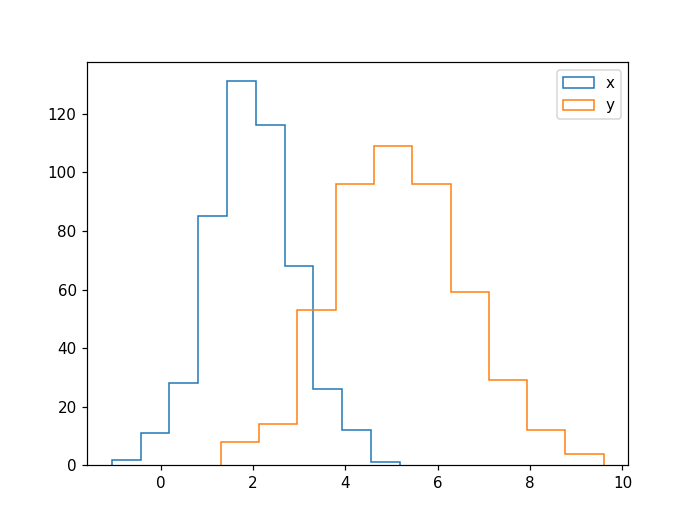

In [25]:
# histogram them
fig, ax = pyplot.subplots()
ax.hist(posterior['x'], bins=10, histtype='step', label='x')
ax.hist(posterior['y'], bins=10, histtype='step', label='y')
ax.legend()
fig.show()

Let's check the mean and variance of our estimated posterior. These should be $\bar{x} \approx 2, \sigma^2_{x} \approx 1$ and $\bar{y} \approx 5, \sigma^2_{y} \approx 2$:

In [26]:
for param in posterior:
    s = posterior[param]
    print(param, 'mean: {}'.format(s.mean()), 'var: {}'.format(s.var()))

x mean: 1.99478140402679 var: 0.8584428515335814
y mean: 5.178616585856629 var: 1.9987894875419652


The values are close, but not exact. This isn't too surprising since we only have $\mathcal{O}(100)$ samples. To get more samples, the sampler can be run longer.

## Create an animation of the results

To visualize the results, we'll create an animation showing how the chains evolved. We'll do this by plotting one point for each chain, with each frame in the animation representing a single iteration.

***Note: To keep file size down, the animation has not been created for the version of this notebook uploaded to the repository.***

In [ ]:
from matplotlib import animation

In [ ]:
# Prepare an array to create a density map showing the shape of the model posterior
npts = 100
xmean, ymean = model.likelihood_dist.mean
xsig = model.likelihood_dist.cov[0,0]**0.5
ysig = model.likelihood_dist.cov[1,1]**0.5
X, Y = numpy.mgrid[xmean-3*xsig:xmean+3*xsig:complex(0, npts),
                   ymean-3*ysig:ymean+3*ysig:complex(0, npts)]
Z = numpy.zeros(X.shape)
for ii in range(Z.shape[0]):
    for jj in range(Z.shape[1]):
        logl, logp = model(x=X[ii,jj], y=Y[ii,jj])
        Z[ii, jj] = numpy.exp(logl+logp)

In [ ]:
# we'll just animate the first 200 iterations; change this to
# nframes = xdata.shape[1]
# if you want to see all iterations
nframes = 200

In [ ]:
fig, ax = pyplot.subplots()

positions = sampler.positions
xdata = positions['x']
ydata = positions['y']

# Plot density map showing the shape of the true posterior density
ax.imshow(numpy.rot90(Z), extent=[X.min(), X.max(), Y.min(), Y.max()],
          aspect='auto', cmap='binary', zorder=-3)

# Put an x at the maximum posterior point
ax.scatter(model.mean[0], model.mean[1], marker='x', color='w', s=10, zorder=-2)
ax.set_xlabel('x')
ax.set_ylabel('y')
# create the scatter points
ptsize = 60

# we'll include the last bufferlen number of steps a chain visited, having the size and transparency
# exponentially damped with each new frame
bufferlen = 16
alphas = numpy.exp(-4*(numpy.arange(bufferlen))/float(bufferlen))
sizes = ptsize * alphas
#colors = numpy.array(['C{}'.format(ii) for ii in range(nchains)])
colors = numpy.arange(nchains)
plts = [ax.scatter(xdata[:, bufferlen-ii-1], ydata[:, bufferlen-ii-1], c=colors, s=sizes[ii],
                   edgecolors='w', linewidths=0.5,
                   alpha=alphas[ii], zorder=bufferlen-ii, marker='s' if ii==0 else 'o', cmap='jet')
        for ii in range(bufferlen)]
# put a + showing the average of the chain positions at the current iteration
meanplt = ax.scatter(xdata[:,0].mean(), ydata[:,0].mean(), marker='P', c='w', edgecolors='k', linewidths=0.5,
                     zorder=bufferlen+1)

# add some text giving the iteration
itertxt = 'Iteration {}'
txt = ax.annotate(itertxt.format(1), (0.03, 0.94), xycoords='axes fraction')

def animate(ii):
    txt.set_text(itertxt.format(ii+1))
    for jj,plt in enumerate(plts):
        plt.set_offsets(numpy.array([xdata[:, max(ii-jj, 0)], ydata[:, max(ii-jj, 0)]]).T)
    meanplt.set_offsets([xdata[:,ii].mean(), ydata[:,ii].mean()])
    # zoom in as it narrows on the result
    istart = max(ii-bufferlen, 0)
    # smooth it out a bit
    xmin = numpy.array([xdata[:, max(istart-kk, 0):].min() for kk in range(50)]).mean()
    xmax = numpy.array([xdata[:, max(istart-kk, 0):].max() for kk in range(50)]).mean()
    ymin = numpy.array([ydata[:, max(istart-kk, 0):].min() for kk in range(50)]).mean()
    ymax = numpy.array([ydata[:, max(istart-kk, 0):].max() for kk in range(50)]).mean()
    ax.set_xlim((1.1 if xmin < 1 else 0.9)*xmin, (0.9 if xmax < 1 else 1.1)*xmax)
    ax.set_ylim((1.1 if ymin < 1 else 0.9)*ymin, (0.9 if ymax < 1 else 1.1)*ymax)


ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=160, blit=True)

Save the animation:

In [ ]:
ani.save('chain_animation.mp4')

The result:

In [ ]:
%%HTML
<video width="640" height="480" controls>
  <source src="chain_animation.mp4" type="video/mp4">
</video>